In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
from summary_testing.llm.GeminiCaller import GeminiCaller
from summary_testing.dataset_assembly.PatientSummaryGenerator import PatientSummaryGenerator
from summary_testing.llm.prompts import SummaryPromptV1, SummaryPromptV0
from summary_testing.statistical_tests.dataset_utils import text_analysis, merge_two_summary_datasets
from summary_testing.statistical_tests.plotting_utils import readability_change_histogram
from summary_testing.statistical_tests.bootstrap import paired_bootstrap_ci, interpret_bootstrap_ci_intervals
from summary_testing.statistical_tests.permutation_test import paired_permutation_test, interpret_permutation_test
from datasets import load_dataset, concatenate_datasets
import numpy as np
import os
import copy
import seaborn as sns
from dotenv import load_dotenv

In [64]:
load_dotenv()

True

In [84]:
def concatenate_fields(example):
    example['model_input'] = example['title'] + "\n" + example['patient']
    return example
    
def assemble_example_dataset():

    nsample = 250
    dataset = load_dataset("aisc-team-b1/PMC-Patients")
    random_state = np.random.RandomState(42)
    chosen_data = random_state.randint(0, len(dataset["train"]), nsample)
    filtered_dataset = dataset["train"].select(chosen_data).select_columns(['patient_id', 'title', 'patient'])
    filtered_dataset = filtered_dataset.map(concatenate_fields)
    return filtered_dataset

def assemble_replicated_dataset():

    """
    For use when we want to estimate the additional uncertainty that comes 
    from multiple runs of the LLM with the same input and same prompt
    """

    NSAMPLE = 30
    NRUNS = 20
    dataset = load_dataset("aisc-team-b1/PMC-Patients")
    random_state = np.random.RandomState(42)
    chosen_data = random_state.randint(0, len(dataset["train"]), NSAMPLE)
    filtered_dataset = dataset["train"].select(chosen_data).select_columns(['patient_id', 'title', 'patient'])
    replicated_datasets = [filtered_dataset for _ in range(NRUNS)]
    replicated_dataset = concatenate_datasets(replicated_datasets)
    replicated_dataset = replicated_dataset.map(concatenate_fields)
    return replicated_dataset

In [85]:
example_dataset = assemble_example_dataset()
replicated_dataset = assemble_replicated_dataset()

In [21]:
gemini_api_key = os.environ.get("GEMINI_API_KEY")
llm_caller = GeminiCaller(api_key=gemini_api_key,model="gemini-2.0-flash")

In [24]:
print(SummaryPromptV1.system_message)


You are a helpful assistant who specializes in summarizing complex medical information at the level a child would understand.
You will receive some detailed doctor's notes about a patient from the PMC-Patients dataset and you must summarize it further, following these instructions:

- Your summary must capture the most important aspects of the patient summary in fewer than 100 words
- Return just the summary with no other commentary
- Your summary should be accessible to someone with a 6th grade reading level. Target a Flesch–Kincaid readability score of 80
    


In [31]:
v1_generator = PatientSummaryGenerator(llm_caller, SummaryPromptV1)
v0_generator = PatientSummaryGenerator(llm_caller, SummaryPromptV0)

## Generate summaries on dev set for prompt v0

In [33]:
dataset_w_summary_v0 = v0_generator.generate(copy.deepcopy(example_dataset), "datasets/v0_summaries.json")

Creating json from Arrow format: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.06ba/s]


## Generate summaries on dev set for prompt v1

In [28]:
dataset_w_summary_v1 = v1_generator.generate(copy.deepcopy(example_dataset), "datasets/v1_summaries.json")

Creating json from Arrow format: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.87ba/s]


In [54]:
dataset_v0 = load_dataset("json",data_files="datasets/v0_summaries.json")
dataset_v1 = load_dataset("json",data_files="datasets/v1_summaries.json")

merged_datasets = merge_two_summary_datasets(
    dataset_v0,
    dataset_v1,
    df1_name="v0",
    df2_name="v1",
)

In [56]:
merged_datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      250 non-null    int64  
 1   model_input                     250 non-null    object 
 2   input_flesch_reading_ease       250 non-null    float64
 3   input_syllables_per_word        250 non-null    float64
 4   input_words_per_sentence        250 non-null    float64
 5   v0_summary                      250 non-null    object 
 6   v1_summary                      250 non-null    object 
 7   v0_summary_flesch_reading_ease  250 non-null    float64
 8   v1_summary_flesch_reading_ease  250 non-null    float64
 9   v0_summary_syllables_per_word   250 non-null    float64
 10  v1_summary_syllables_per_word   250 non-null    float64
 11  v0_summary_words_per_sentence   250 non-null    float64
 12  v1_summary_words_per_sentence   250 

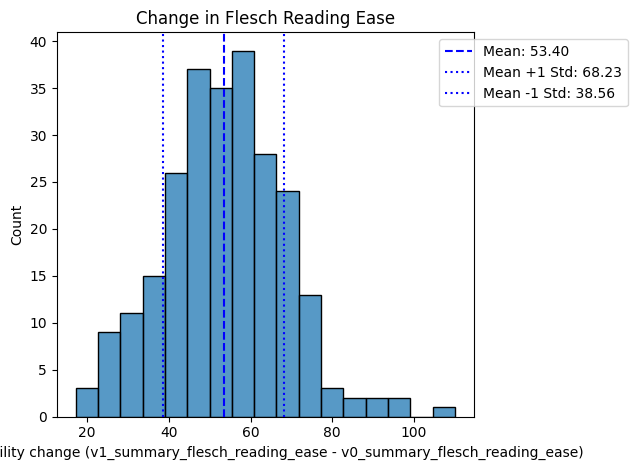

In [59]:
readability_change_histogram(
    merged_datasets,
    x="v0_summary_flesch_reading_ease",
    y="v1_summary_flesch_reading_ease"
)

In [68]:
permutation_results = paired_permutation_test(
    x = merged_datasets["v0_summary_flesch_reading_ease"],
    y = merged_datasets["v1_summary_flesch_reading_ease"],
    difference_statistic=np.mean
)
permutation_results
interpret_permutation_test(
    statistic=permutation_results["test_statistic"],
    p_value=permutation_results["p_value"],
    p_value_threshold=0.05
)

The mean readability change is 53.40 (positive means increasing readability)
The paired permutation test p value is 0.000
This means we reject the null hypothesis and conclude that there is a positive change in readability


In [70]:
bootstrap_results = paired_bootstrap_ci(
    x = merged_datasets["v0_summary_flesch_reading_ease"],
    y = merged_datasets["v1_summary_flesch_reading_ease"],
    difference_statistic=np.mean
)
interpret_bootstrap_ci_intervals(
    statistic=bootstrap_results["test_statistic"],
    ci_lower=bootstrap_results["confidence_interval"][0],
    ci_upper=bootstrap_results["confidence_interval"][1]
)

The mean readability change is 53.40 (positive means increasing readability)
The paired bootstrap confidence range is 51.536 to 55.275
This suggests we should reject the null hypothesis and conclude there was a meaningful positive change in readability


## Generate summaries for replicated dataset
May take some time. Be aware of API costs

In [86]:
dataset_w_summary_replicated_v1 = v1_generator.generate(
    copy.deepcopy(replicated_dataset), 
    "v1_summaries_replicated_temp_1.json",
    temperature=1
)

Creating json from Arrow format: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 48.44ba/s]


In [87]:
dataset_w_summary_replicated_v1_stats = dataset_w_summary_replicated_v1.map(
    text_analysis, fn_kwargs={"model":"gemini-flash-2.0"}
)

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 3748.01 examples/s]


In [88]:
df_replicated_v1 = dataset_w_summary_replicated_v1_stats.to_pandas()
df_replicated_v1_stats = df_replicated_v1.groupby("patient_id").agg(
    mean=("summary_flesch_reading_ease", "mean"),
    std=("summary_flesch_reading_ease", "std")
).reset_index()

Text(0.5, 0, 'Standard deviation')

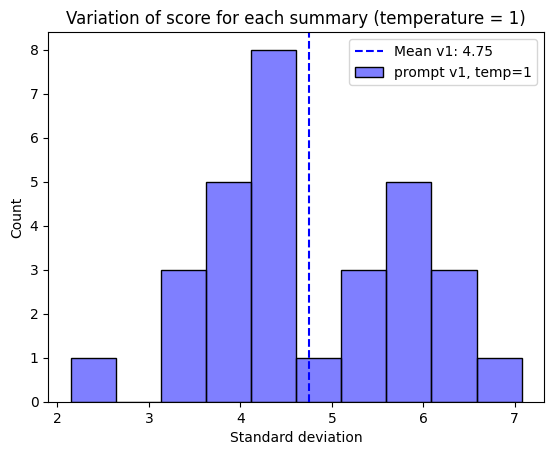

In [89]:
df = df_replicated_v1_stats.copy()
ax = sns.histplot(
    x="std",
    data=df,
    binwidth=0.5,
    label="prompt v1, temp=1",
    color="blue",
    alpha=0.5
)
ax.axvline(
    x=df["std"].mean(),
    linestyle="--", 
    color="blue", 
    label="Mean v1: {:.2f}".format(df["std"].mean())
)
ax.legend()
ax.set_title("Variation of score for each summary (temperature = 1)")
ax.set_xlabel("Standard deviation")